# Regular Variation Bias Correction

In [6]:
library(mvtnorm)
library(ggplot2)
library(tidyverse)

In [7]:
estimateIsoR <- function(dat, p, gamma, xi, theta) {

    q <- nrow(dat)^(-gamma)

    empSurvFixedCoord <- function(radius, angle, prob) {
        xCoord <- radius*cos(angle)
        yCoord <- radius*sin(angle)
        exceedanceProb <- mean((dat[,1] > xCoord) & (dat[,2] > yCoord))
        return(exceedanceProb - prob)
    }

    maxRad <- max(10 + sqrt((dat[,1]**2) + (dat[,2]**2)))

    radius_q <- uniroot(empSurvFixedCoord, interval=c(0, maxRad), angle=theta,
                             prob=q)$root
    
    radius_p <- radius_q*((q/p)^(xi))

    return(radius_p)
}

In [24]:
B <- 100
n <- 10000
p <- 5/n
gamma <- 1/2
xi <- 1/4
theta <- pi/4

n_iter <- 10
est_rs <- rep(NA, n_iter)
bias_rs <- rep(NA, n_iter)

for (i in 1:n_iter) {

    dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
    est_rs[i] <- estimateIsoR(dat, p, gamma, xi, theta)
    boot_rs <- rep(NA, B)

    for (j in 1:B) {
        boot_dat <- dat %>% sample_frac(1, replace=TRUE)
        boot_rs[j] <- estimateIsoR(boot_dat, p, gamma, xi, theta)
    }
    bias_rs[i] <- est_rs[i] - mean(boot_rs)
    
}

In [25]:
bias_rs

[1]  0.09683564 -0.02438549  0.05047836 -0.03700495 -0.01402338 -0.08097916
 [7]  0.05989301  0.03104830  0.02234000  0.01109169

In [15]:
true_quantile <- qmvt(p, tail='upper.tail', df=4, sigma=matrix(c(1, 0.7, 0.7, 1), nrow = 2))
r_true <- (true_quantile$quantile)*sqrt(2)

In [52]:
r_true

[1] 9.575535

In [44]:
res <- readRDS('/global/u1/j/jbbutler/isolines_uq/data/theoretical_data/regular_variation_bias_correction/bivariate_t_4_dof.RData')
res_df <- data.frame(res)
colnames(res_df) <- c('est_r', 'bias_r')
res_df$corrected <- res_df$est_r + res_df$bias_r

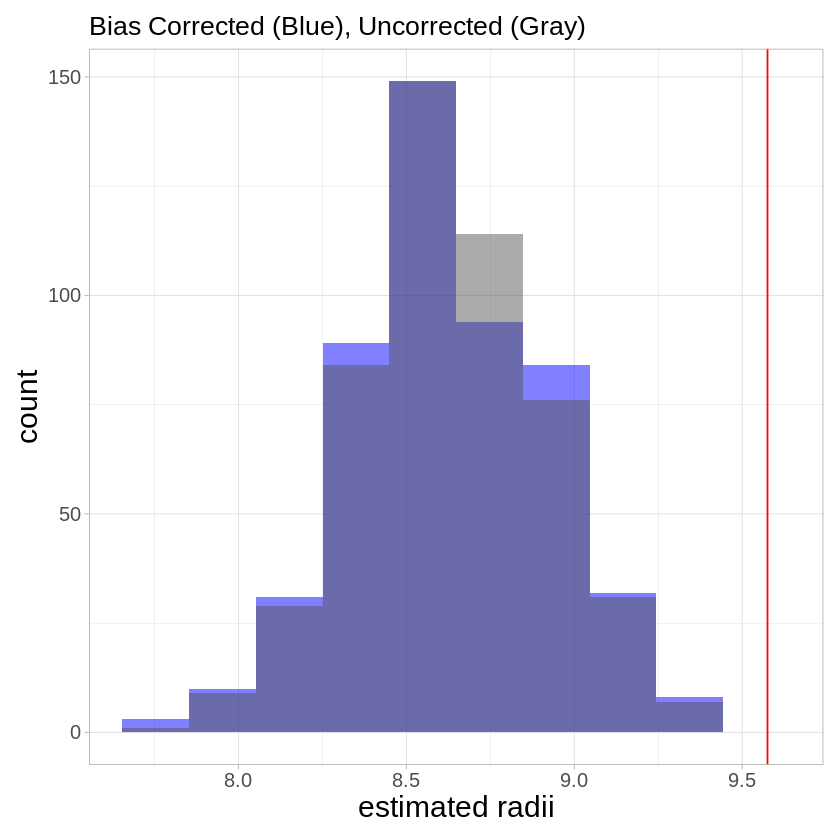

In [63]:
ggplot(res_df) + geom_histogram(aes(x=corrected), fill='blue', bins=10, alpha=0.5) + geom_histogram(aes(x=est_r), bins=10, alpha=0.5) + geom_vline(xintercept=r_true, color='red') + ggtitle('Bias Corrected (Blue), Uncorrected (Gray)') + xlab('estimated radii') + theme_light() + theme(axis.title = element_text(size = 18), 
      axis.text = element_text(size = 12), 
      text = element_text(size = 12),
      plot.title = element_text(size=16),
      plot.margin = margin(10, 10, 10, 10))

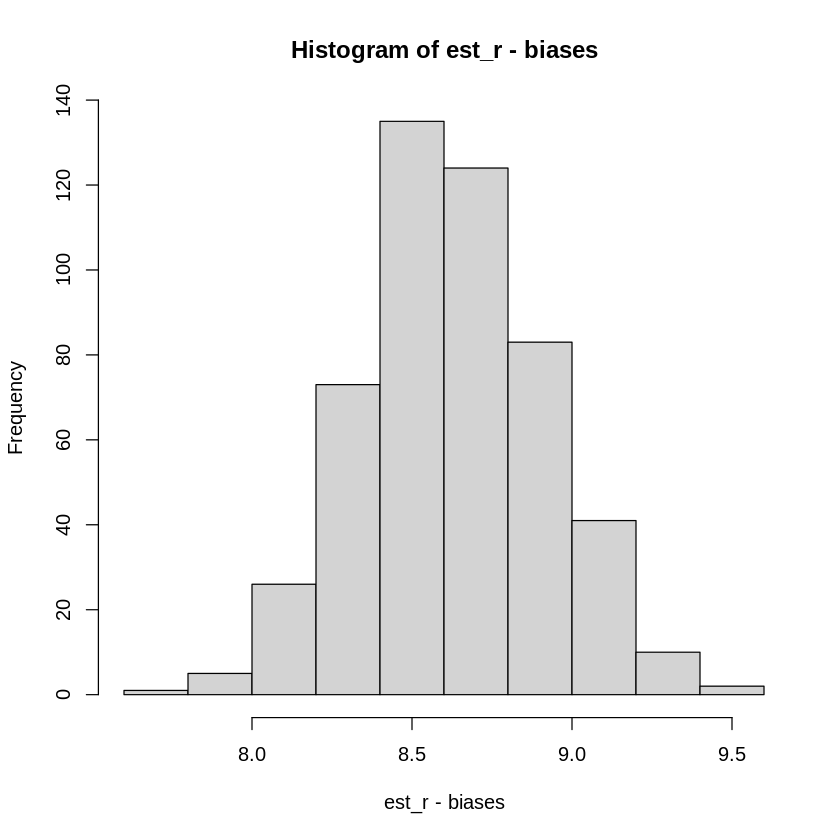

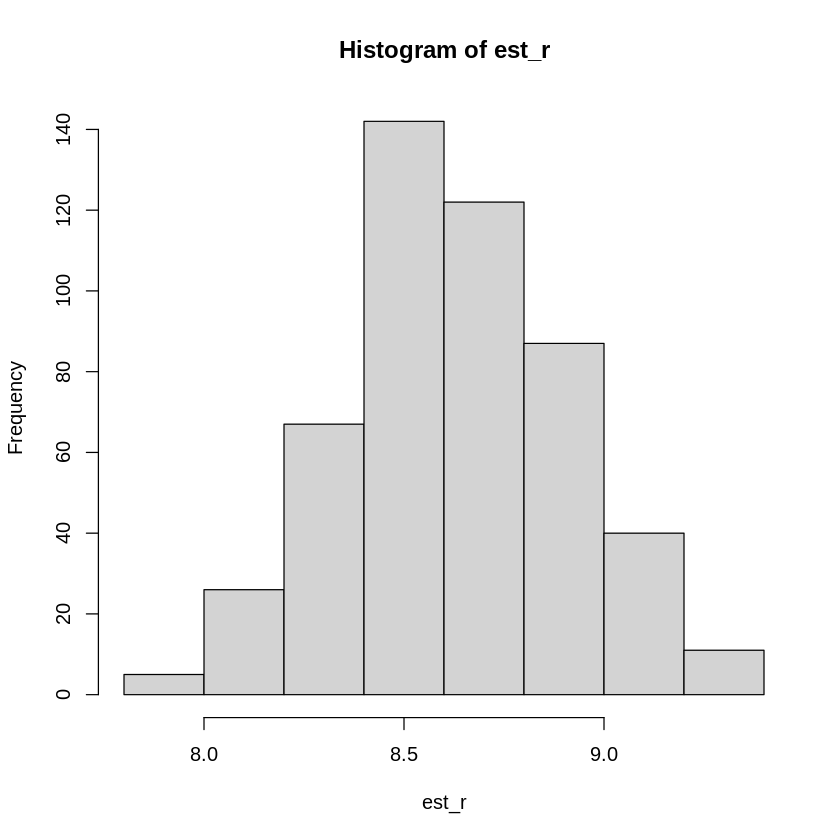

In [43]:
hist(est_r)